# Extract RGB values from image

There are broadly three steps to find the dominant colors in an image:

- Extract RGB values into three lists.
- Perform k-means clustering on scaled RGB values.
- Display the colors of cluster centers.

<center><img src="images/04.01.jpg"  style="width: 400px, height: 300px;"/></center>

In [1]:
# Import image class of matplotlib
import matplotlib.image as img
r = []
g = []
b = []
# Read batman image and print dimensions
batman_image = img.imread('images/04.01.jpg')
print(batman_image.shape)

# Store RGB values of all pixels in lists r, g and b
for row in batman_image:
    for temp_r, temp_g, temp_b in row:
        r.append(temp_r)
        g.append(temp_g)
        b.append(temp_b)

(169, 269, 3)


# How many dominant colors?

Construct an elbow plot with the DataFrame. How many dominant colors are present?

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Import the kmeans and vq functions
from scipy.cluster.vq import kmeans, vq

batman_df = pd.DataFrame({
    "red" : r,
    "green" : g,
    "blue" : b
})

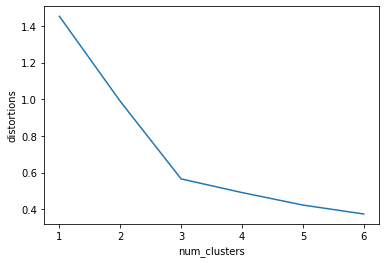

In [9]:
from scipy.cluster.vq import whiten
batman_df["scaled_red"] = whiten(batman_df["red"])
batman_df["scaled_green"] = whiten(batman_df["green"])
batman_df["scaled_blue"] = whiten(batman_df["blue"])

distortions = []
num_clusters = range(1, 7)

# Create a list of distortions from the kmeans function
for i in num_clusters:
    cluster_centers, distortion = kmeans(batman_df[['scaled_red' , 'scaled_green', 'scaled_blue']], i)
    distortions.append(distortion)

# Create a DataFrame with two lists, num_clusters and distortions
elbow_plot = pd.DataFrame({'num_clusters':num_clusters,
'distortions' : distortions})

# Create a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

# Display dominant colors

To display the dominant colors, convert the colors of the cluster centers to their raw values and then converted them to the range of 0-1, using the following formula: `converted_pixel = standardized_pixel * pixel_std / 255`

In [14]:
cluster_centers, distortion = kmeans(batman_df[['scaled_red' , 'scaled_green', 'scaled_blue']], 3)
cluster_centers

array([[ 0.30021892,  0.20560515,  0.16398733],
       [-0.65917736,  1.31008137,  1.56291797],
       [ 1.61102175, -1.21474604, -0.64157567]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


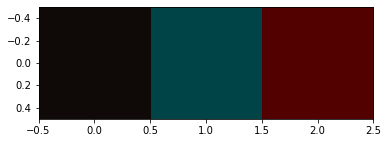

In [16]:
colors = []
# Get standard deviations of each color
r_std, g_std, b_std = batman_df[['red', 'green', 'blue']].std()

for cluster_center in cluster_centers:
    scaled_r, scaled_g, scaled_b = cluster_center
    # Convert each standardized value to scaled value
    colors.append((
        scaled_r * r_std / 255,
        scaled_g * g_std / 255,
        scaled_b * b_std / 255
    ))

# Display colors of cluster centers
plt.imshow([colors])
plt.show()

# TF-IDF of movie plots

Let us use the plots of randomly selected movies to perform document clustering on. Before performing clustering on documents, they need to be cleaned of any unwanted noise (such as special characters and stop words) and converted into a sparse matrix through TF-IDF of the documents.

In [20]:
plot_df = pd.read_csv("dataset/movies_plot.csv")
plots  = list(plot_df["Plot"].values)
print(type(plots))
print(plots[0])
plot_df.head()

<class 'list'>
Cable Hogue is isolated in the desert, awaiting his partners, Taggart and Bowen, who are scouting for water. The two plot to seize what little water remains to save themselves. Cable, who hesitates to defend himself, is disarmed and abandoned to almost certain death.
Confronted with sandstorms and other desert elements, Cable bargains with God. Four days later, about to perish, he stumbles upon a muddy pit. He digs and discovers an abundant supply of water.
After discovering that his well is the only source of water between two towns on a stagecoach route, he decides to live there and build a business. Cable's first paying customer is the Rev. Joshua Duncan Sloane, a wandering minister of a church of his own revelation. Joshua doubts the legitimacy of Cable's claim to the spring, prompting Cable to race into town to file at the land office.
Cable faces the mockery of everyone he tells about his discovery. That does not deter him from buying 2 acres (0.8 ha) surrounding h

,Title,Plot
0,The Ballad of Cable Hogue,"Cable Hogue is isolated in the desert, awaitin..."
1,Monsters vs. Aliens,"In the far reaches of space, a planet explodes..."
2,The Bandit Queen,Zarra Montalvo is the daughter of an American ...
3,Broken Arrow,Major Vic Deakins (John Travolta) and Captain ...
4,Dolemite,Dolemite is a pimp and nightclub owner who is ...


In [31]:
# Import TfidfVectorizer class from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, max_features=50,
min_df=0.1, stop_words=stop_words)  # , tokenizer=remove_noise

# Use the .fit_transform() method on the list plots
tfidf_matrix = tfidf_vectorizer.fit_transform(plots)

# Top terms in movie clusters

Now that you have created a sparse matrix, generate cluster centers and print the top three terms in each cluster. Use the `.todense()` method to convert the sparse matrix, tfidf_matrix to a normal matrix for the `kmeans()` function to process. Then, use the `.get_feature_names()` method to get a list of terms in the tfidf_vectorizer object

In [32]:
num_clusters = 2

# Generate cluster centers through the kmeans function
cluster_centers, distortion = kmeans(tfidf_matrix.todense(), num_clusters)

# Generate terms from the tfidf_vectorizer object
terms = tfidf_vectorizer.get_feature_names()

for i in range(num_clusters):
    # Sort the terms and print top 3 terms
    center_terms = dict(zip(terms, cluster_centers[i]))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:3])

['film', 'life', 'family']
['one', 'back', 'two']


# Clustering with many features

What should you do if you have too many features for clustering?

- Reduce features using a technique like Factor Analysis

# Basic checks on clusters

In the FIFA 18 dataset, we have concentrated on defenders in previous exercises. Let us try to focus on attacking attributes of a player. Pace (`pac`), Dribbling (`dri`) and Shooting (`sho`) are features that are present in attack minded players. In this exercise, k-means clustering has already been applied on the data using the scaled values of these three attributes. Try some basic checks on the clusters so formed.

In [34]:
fifa = pd.read_csv("dataset/fifa_18_sample_data.csv")
fifa['scaled_sliding_tackle'] = whiten(fifa['sliding_tackle'])
fifa['scaled_aggression'] = whiten(fifa[ 'aggression'])

# Fit the data into a k-means algorithm
cluster_centers,_ = kmeans(fifa[['scaled_sliding_tackle' , 'scaled_aggression']], 3)

# Assign cluster labels
fifa['cluster_labels'],_ = vq(fifa[['scaled_sliding_tackle' , 'scaled_aggression']], cluster_centers)


In [35]:

# Print the size of the clusters
print(fifa.groupby('cluster_labels')['ID'].count())

# Print the mean value of wages in each cluster
print(fifa.groupby('cluster_labels')['eur_wage'].mean())

cluster_labels
0    311
1    507
2    182
Name: ID, dtype: int64
cluster_labels
0    77279.742765
1    68502.958580
2    58609.890110
Name: eur_wage, dtype: float64


# FIFA 18: what makes a complete player?

The overall level of a player in FIFA 18 is defined by six characteristics: pace (`pac`), shooting (`sho`), passing (`pas`), dribbling (`dri`), defending (`def`), physical (`phy`). you will use all six characteristics to create clusters. The data for this exercise is stored in a pandas DataFrame, `fifa`

<center><img src="images/04.02.jpg"  style="width: 400px, height: 300px;"/></center>


In [41]:
fifa["pac_scaled"] = whiten(fifa["pac"])
fifa["sho_scaled"] = whiten(fifa["sho"])
fifa["pas_scaled"] = whiten(fifa["pas"])
fifa["dri_scaled"] = whiten(fifa["dri"])
fifa["def_scaled"] = whiten(fifa["def"])
fifa["phy_scaled"] = whiten(fifa["phy"])
scaled_features = ["pac_scaled", "sho_scaled", "pas_scaled", "dri_scaled", "def_scaled", "phy_scaled"]


In [42]:
# Create centroids with kmeans for 2 clusters
cluster_centers,_ = kmeans(fifa[scaled_features], 2)

# Assign cluster labels and print cluster centers
fifa['cluster_labels'], _ = vq(fifa[scaled_features], cluster_centers)
print(fifa.groupby('cluster_labels')[scaled_features].mean())




                pac_scaled  sho_scaled  pas_scaled  dri_scaled  def_scaled  \
cluster_labels                                                               
0                 5.454041    3.668379    7.174064    6.767575    3.966702   
1                 6.684070    5.430915    8.455704    8.514977    2.500552   

                phy_scaled  
cluster_labels              
0                 9.209874  
1                 8.334066  


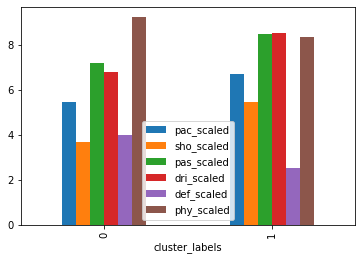

In [43]:
# Plot cluster centers to visualize clusters
fifa.groupby('cluster_labels')[scaled_features].mean().plot(legend=True, kind='bar')
plt.show()

In [44]:
# Get the name column of first 5 players in each cluster
for cluster in fifa['cluster_labels'].unique():
    print(cluster, fifa[fifa['cluster_labels'] == cluster]['name'].values[:5])

1 ['Cristiano Ronaldo' 'L. Messi' 'Neymar' 'L. Suárez' 'M. Neuer']
0 ['Sergio Ramos' 'G. Chiellini' 'L. Bonucci' 'J. Boateng' 'D. Godín']
